<center><a href="https://5loi.com/about_loi"><img src="images/DLI_Header.png" width="400" height="186" /></a></center>

# 4b. 部署模型
现在我们已对模型进行了有效的训练，接下来就该实际应用它了。本练习中，我们将给模型展示新图像，让它判断新图像里的手语所对应的字母表中的正确字母。

## 4b.1 目标
完成这一章节后，您将能够：
* 从磁盘加载一个已经训练过的模型；
* 为基于不同格式图像训练而得到的模型，重新格式化图像
* 使用训练过的模型从未见过的新图像进行推理，并评估其性能

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4b.2 加载模型
我们当前正在使用新的 notebook，所以需要重新加载已保存的训练好的模型。前一个练习中的保存操作创建了一个名为 `asl_model` 的文件。我们可以通过选择同一文件名来加载该模型。

因为我们的模型用了一个 [自定义的模型](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html)，所以需要加载这个类的代码。我们已经在 [utils.py](./uitls.py) 中保存了一份代码。

In [2]:
from utils import MyConvBlock

现在我们已经定义了 `MyConvBlock`，可以用 [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html) 从路径加载模型。可以用 `map_location` 指定设备。当我们打印模型时，它看起来与上一个 notebook 中的一样吗？

In [3]:
model = torch.load('model.pth', map_location=device)
model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

我们还可以验证模型是否在我们的 GPU 上。

In [4]:
next(model.parameters()).device

device(type='cuda', index=0)

## 4b.3 为模型准备图像
现在，我们就来使用模型对其先前从未见过的新图像进行预测，此过程也称为推理。我们在 `data/asl_images` 文件夹中为您提供了一组图像。请尝试在左侧的文件导航区域打开并浏览这些图像。

您会发现，此文件夹中的图像比数据集里的图像的分辨率要高得多，而且还是彩色的。别忘了，数据集中的图像为 28x28 像素，且为灰度图。请务必牢记，无论何时使用模型进行预测，输入皆须与训练模型所用数据的形状相匹配。对于此模型，训练数据集的形状如下：(27455, 28, 28, 1)，这对应于 27,455 个 28x28 像素的图像，其中每个图像皆具有一个颜色通道（灰度图）。

### 4b.3.1 显示图像
使用模型对新图像进行预测时，同时显示输入图像对我们也有用。我们可以使用 matplotlib 库来执行此操作。

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

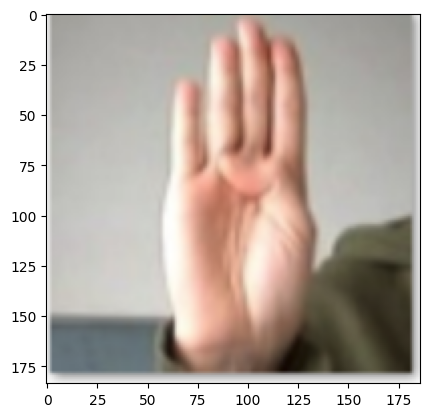

In [6]:
show_image('data/asl_images/b.png')

### 4b.3.2 缩放图像
数据集中的图像为 28x28 像素，且为灰度图。我们需要确保将相同大小和颜色的图像传入模型的 `predict` 方法中。目前有好几种方法使用 Python 对图像进行编辑，但 TorchVision 已有一个内置的 [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html) 函数。我们可以通过 [ImageReadMode](https://pytorch.org/vision/stable/generated/torchvision.io.ImageReadMode.html#torchvision.io.ImageReadMode) 让它知道读取的图片是什么类型。

In [7]:
image = tv_io.read_image('data/asl_images/b.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[247, 223, 178,  ..., 223, 231, 238],
         [245, 221, 178,  ..., 213, 223, 232],
         [244, 220, 177,  ..., 204, 217, 228],
         ...,
         [247, 243, 238,  ..., 223, 231, 238],
         [249, 246, 243,  ..., 232, 238, 243],
         [250, 248, 246,  ..., 240, 243, 246]]], dtype=torch.uint8)

让我们看下图片的维度。

In [8]:
image.shape

torch.Size([1, 184, 186])

这张图像比我们训练时使用的要大得多。我们可以再次使用 TorchVision 的 Transforms 来将数据转换为我们模型期望的形式。

我们将:
* 用 [ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html) 将图像转换为浮点型
  * 我们将 `scale` 设置为 `True` 以将 [0, 255] 转换为 [0, 1]
* 使用 [Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize) 将图像调整为 28 x 28 像素
* 使用 [Grayscale](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Grayscale.html#torchvision.transforms.v2.Grayscale) 将图像转换为灰度
  * 这一步实际上不会做任何事情，因为我们的模型已经是灰度的，但在这里添加它是为了展示获取灰度图像的另一种方法。

In [9]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

让我们在一张图像上测试 `preprocess_trans`，以确保它正常工作：

In [10]:
processed_image = preprocess_trans(image)
processed_image

tensor([[[0.6960, 0.6279, 0.6348, 0.6493, 0.6584, 0.6599, 0.6638, 0.6630,
          0.6652, 0.6677, 0.6711, 0.6696, 0.6661, 0.6677, 0.7103, 0.6559,
          0.6369, 0.6507, 0.6464, 0.6379, 0.6293, 0.6216, 0.6139, 0.6074,
          0.5984, 0.5895, 0.5836, 0.6977],
         [0.7013, 0.6388, 0.6480, 0.6578, 0.6647, 0.6687, 0.6709, 0.6734,
          0.6746, 0.6794, 0.6814, 0.6784, 0.6902, 0.6801, 0.7648, 0.6606,
          0.5610, 0.6348, 0.6418, 0.6509, 0.6417, 0.6308, 0.6252, 0.6197,
          0.6095, 0.6007, 0.5923, 0.6773],
         [0.7061, 0.6479, 0.6588, 0.6668, 0.6743, 0.6811, 0.6845, 0.6848,
          0.6872, 0.6898, 0.6913, 0.6909, 0.7671, 0.6833, 0.6945, 0.6803,
          0.4720, 0.6061, 0.5686, 0.6548, 0.6566, 0.6471, 0.6380, 0.6273,
          0.6198, 0.6124, 0.6078, 0.6837],
         [0.7165, 0.6603, 0.6699, 0.6770, 0.6821, 0.6880, 0.6959, 0.7001,
          0.7027, 0.7014, 0.7009, 0.7041, 0.8257, 0.6885, 0.6387, 0.7202,
          0.4938, 0.6614, 0.5266, 0.6351, 0.6649, 0.6595,

数字看起来是正确的，但维度如何？

In [11]:
processed_image.shape

torch.Size([1, 28, 28])

接下来，让我们绘制图像，看看它是否像我们训练时的样子。

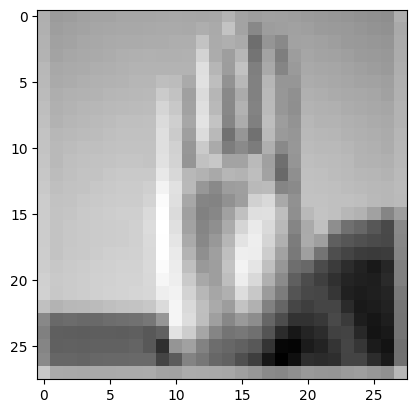

In [12]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

看起来不错！让我们将它传递给模型。

### 4b.4 进行预测

好的，现在准备好进行预测了！我们的模型仍然期望接收一批图像。[squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.htmlhttps://pytorch.org/docs/stable/generated/torch.squeeze.html) 能移除 1 个维度，[unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.htmlhttps://pytorch.org/docs/stable/generated/torch.unsqueeze.html) 则在我们指定的索引处添加 1 个维度。第一个维度通常是批次维度，所以我们可以使用 `.unsqueeze(0)`。

In [13]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

接下来，我们应该确保输入张量与模型在同一个 `device` 上。

In [14]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

现在我们准备将它传递给模型了！

In [15]:
output = model(batched_image_gpu)
output

tensor([[-25.1201,  16.4137, -14.6535, -19.2388,  -1.2945,  -8.8808, -15.6060,
         -21.2725,  -8.2531, -14.1520, -24.7590, -15.3134, -11.8724, -25.0560,
         -11.7771, -18.1903, -27.3147, -28.0218, -26.5947,  -0.9370, -33.4578,
          -6.1470, -11.2993, -26.2464]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### 4b.4.1 理解预测结果

预测结果的格式是长度为 24 的一维数组。尽管看起来略有差异，但此格式与 y_train 和 y_valid 中的“二值化”的多分类数组相同。数组中的每个元素均为 0 至 1 之间的概率，代表了每个类别的置信度。为了使这个结果更具可读性，我们可以先找出该数组中具有最高概率的那个元素。使用 `numpy` 库和 [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 函数就能轻松完成此操作。

In [16]:
prediction = output.argmax(dim=1).item()
prediction

1

预测结果的数组中的每个元素代表手语字母表中的一个可能的字母。请记住 j 和 z 已排除在外，因为这两个字母涉及手部动作，而我们仅需要处理静态照片。让我们在预测结果的数组的索引值和相应字母之间创建一个映射。

In [17]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

现在我们根据输入预测的索引值找到对应的字母。

In [18]:
alphabet[prediction]

'b'

#### 练习：汇总一切

让我们将上述与预测相关的内容全部置入一个函数中，这样我们就能对输入的图像进行预测。利用上面使用过的功能和步骤，在下方实现这一函数。如果需要帮助，可单击下方的三个点来显示答案。

#### 解答

单击下方的三个点来显示答案。

In [21]:
# SOLUTION
def predict_letter(file_path):
    show_image(file_path)
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    image = preprocess_trans(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    prediction = output.argmax(dim=1).item()
    # convert prediction to letter
    predicted_letter = alphabet[prediction]
    return predicted_letter

'b'

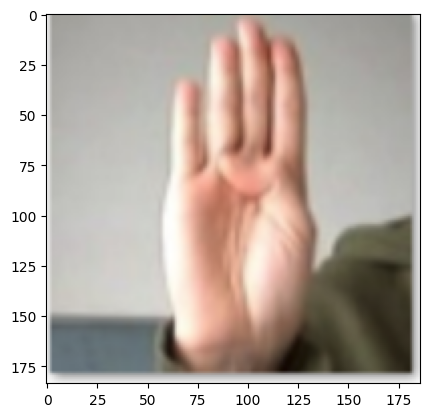

In [22]:
predict_letter("data/asl_images/b.png")

让我们再用 asl_images 数据集中的 'a' 字母图片执行预测函数：

'a'

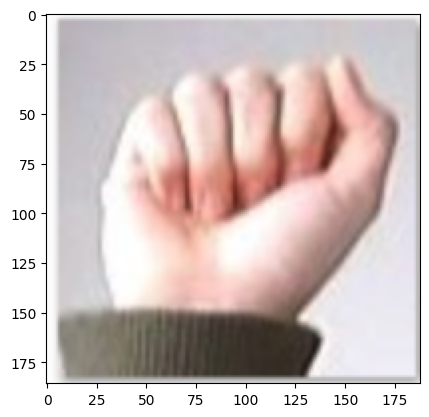

In [23]:
predict_letter("data/asl_images/a.png")

## 4b.5 总结

您已在这些练习中出色地完成了工作！您已经从头开始完成了高精度模型训练的整个流程，然后采用该模型进行了有价值的新预测。如果有时间，您可上传自己的图像放到 data/asl_images 文件夹中，并用这些图像测试模型。这也是学习手语的好机会！例如，您可以尝试用手语比出您名字中的字母。

您可以想象一下，如何在应用中使用此模型来教人手语，甚至帮助失声者与计算机交互。

#### 4b.5.1 清理显存
继续进行后面的内容前，请执行以下单元清理 GPU 显存。

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 4b.5.2 下一步

我们希望你喜欢这些练习。在下一章节中，您将学习在没有强大的数据集时，如何利用深度学习。如果你想阅读和了解当下热门的推理技术，可以看看[这篇很棒的论文](http://web.eecs.umich.edu/~mosharaf/Readings/FB-ML-Edge.pdf)。

现在您已熟悉构建模型并对其工作原理有了一定的了解，我们将把精力转向使用预训练模型来加速您的工作的强大技术。